# Matrix Factorization

* 개인화 추천 시스템의 기본이 되는 Matrix Factorization 모델에 대해서 알아 봅니다.

## 개요

In [1]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

dataset_path = os.environ.get('RCMD_DATASET_PATH', '../dataset')
print('Dataset path', dataset_path)
log_path = os.environ.get('RCMD_LOG_PATH', '../logs')
print('Log path', log_path)

Dataset path ../dataset
Log path ../logs


In [2]:
# MovieLens 100K를 데이터셋을 불러옵니다.
df_ratings = pd.read_csv(os.path.join(dataset_path, 'ratings_100k.csv'))
df_ratings['date'] = df_ratings.pop('timestamp').pipe(lambda x: pd.to_datetime(x, unit='s'))
df_user = pd.read_csv(os.path.join(dataset_path, 'users_100k.csv'), index_col='user id')
df_movie = pd.read_csv(os.path.join(dataset_path, 'movies_100k.csv'), index_col='movie id')

### 상호작용(Iteraction)

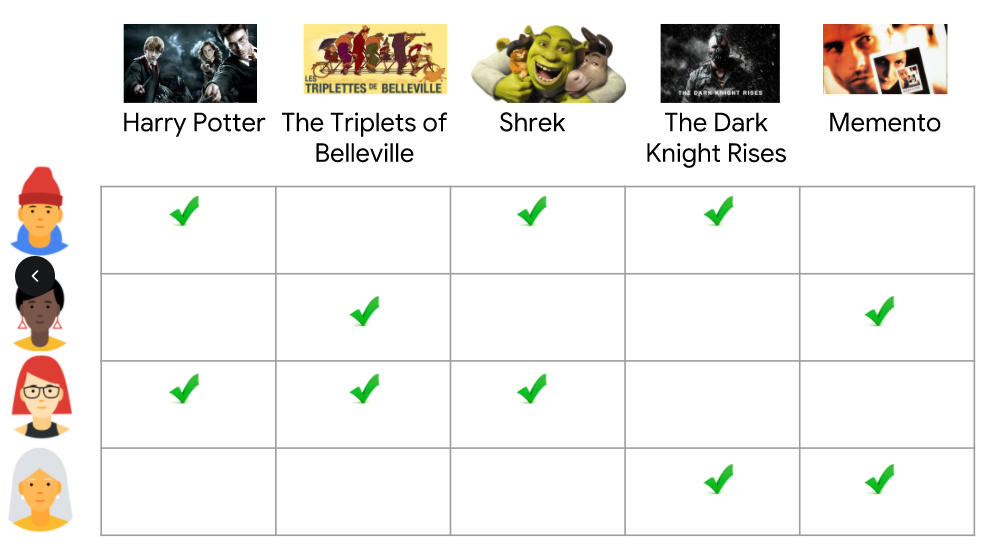

### 개인 취향

사람마다 영화에 대한 취향은 다릅니다. 1000만 관중을 동원한 액션 영화라도, 액션 영화 장르를 싫어하는 사람에게 추천한다면 호응을 얻기 어렵겠죠.

이렇게, 사용자의 아이템에 대한 선호도는 아이템과 사용자 따로 파악하는 것만으로는 부족함이 큽니다. 

개인화 추천에서는 사용자와 아이템의 **상호 작용**을 모델링 하는 것이 **핵심** 입니다.

### 상호 작용 행렬(Iteraction Matrix)

- 사용자의 아이템에 대한 리액션을 테이블화 한 것이 바로 상호 작용 행렬이라고 합니다.

   예제) MovieLen 100K 데이터셋에서 Interaction Matrix를 만들어봅니다.

- 많은 사람이 평점을 남긴 영화 몇 개와 호불호를 분명히 표현한 사용자 몇 명을 뽑아 상호 작용 행렬의 예를 들어 봅니다.

In [3]:
# 1990년대 유명하고 제목이 짧은 영화 몇 편 뽑습니다.
item_index = [1, 226, 96, 402, 69, 29]
df_movie.loc[df_movie.index.isin(item_index)]

,movie title,release date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie id,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
29,Batman Forever (1995),01-Jan-1995,0,1,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
69,Forrest Gump (1994),01-Jan-1994,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
96,Terminator 2: Judgment Day (1991),01-Jan-1991,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
226,Die Hard 2 (1990),01-Jan-1990,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
402,Ghost (1990),01-Jan-1990,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0


In [4]:
# 평점의 표준편차가 1이 넘고 선정한 영화를 3건 넘게 시청한 사용자 중 평점순으로 10명을 뽑습니다.
# 위에서 선정한 영화를 적어도 3편 넘게 본 10명의 사용자를 뽑습니다.
df_user.loc[
    df_ratings.groupby('user id').filter(
        lambda x: x['rating'].std() > 1 and x['item id'].isin(item_index).sum() > 3
    )['user id'].value_counts().head(10).index
]

,age,gender,occupation,zip code
user id,,,,
405,22,F,healthcare,10019
13,47,M,educator,29206
276,21,M,student,95064
416,20,F,student,92626
303,19,M,student,14853
279,33,M,programmer,85251
846,27,M,lawyer,47130
7,57,M,administrator,91344
94,26,M,student,71457


In [5]:
user_index = df_ratings.groupby('user id').filter(
    lambda x: x['rating'].std() > 1 and x['item id'].isin(item_index).sum() > 3
)['user id'].value_counts().head(10).index

# 피벗을 통해 사용자 × 영화로 구성된 상호작용행렬을 만듭니다.
# df_movie, df_user에서 영화 제목 및 사용자 정보를 결합하여
# 파악이 쉽게 데이터프레임을 구성합니다.
df_interaction = df_ratings.loc[
    df_ratings['item id'].isin(item_index) &
    df_ratings['user id'].isin(user_index)
].join(
    df_movie['movie title'], on='item id'
).join(
    df_user[['age', 'gender', 'occupation']].astype('str').apply(
        lambda x: '/'.join(x), axis=1  # 사용자 정보를 '/'를 구분자로 하나의 문자열로 결합
    ).rename('user'), 
    on='user id'
).pivot(
    index='user',  columns='movie title', values='rating' # Interaction 행렬을 만듭니다.
).sort_index().sort_index(axis=1)
df_interaction

movie title,Batman Forever (1995),Die Hard 2 (1990),Forrest Gump (1994),Ghost (1990),Terminator 2: Judgment Day (1991),Toy Story (1995)
user,,,,,,
19/M/student,2.0,4.0,5.0,4.0,5.0,5.0
20/F/student,2.0,4.0,4.0,5.0,4.0,5.0
21/M/student,3.0,4.0,4.0,3.0,5.0,5.0
22/F/healthcare,4.0,2.0,4.0,3.0,3.0,NaN
23/M/programmer,2.0,3.0,4.0,NaN,4.0,4.0
26/M/student,2.0,2.0,3.0,4.0,3.0,4.0
27/M/lawyer,2.0,4.0,5.0,NaN,4.0,NaN
33/M/programmer,2.0,4.0,NaN,NaN,4.0,3.0
47/M/educator,2.0,4.0,4.0,4.0,4.0,3.0


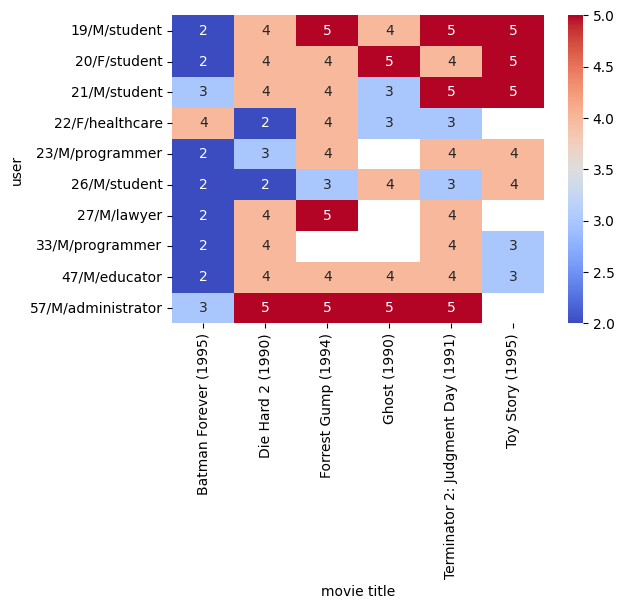

In [6]:
# 상호작용행렬을 Heatmap으로 출력합니다.
plt.figure(figsize=(6, 4))
cmap_coolwarm = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(df_interaction, cmap=cmap_coolwarm, annot=True)
plt.show()

## Matrix Factorization (행렬 요인화)

두 개의 대상 상호작용을 나타내는 행렬에서 행과 열에 대응하는 대상의 특징을 벡터의 형태로 요인화 하는 기법

### Matrix(Symmetric) Factorization Model

- 두 요인을 동일한 크기의 벡터로 요인화한 모델

- 두 개의 특징에 의한 상호 작용의 결과를 내적으로 나타내어 연산과 표현의 효율화

$N_{user}×N_{item}$의 상호작용 행렬(Matrix)을 

$N_{user}×Rank$사용자 행렬과 $N_{item}×Rank$아이템 행렬 두 개의 행렬곱으로 분해하는 모델입니다.

$Interaction = User × Item^T$


> 영화의 수가 1000 개, 사용자의 수가 10000 명이라면 상호작용행렬로 각자의 특성을 나타낸다면
> 
> 1000 × 10000 = 10^7 개의 수가 필요합니다.
> 
> 하지만, 이를 Rank = 100 개인 두 개의 행렬로 나눈다면,
> 1000 × 100 + 10000 × 100 = 10^6 + 10^5 개의 수로 나타낼 수 있고
> 
> 줄어드는 크기는 영화와 사용자가 커질 수록 크게 나타납니다.

Rank와 User 수의 곱, Rank와 Item 수의 곱으로 증가합니다. 

선형적으로 증가되어 상호작용의 **공간 복잡도가 감소**합니다.

뿐만 아니라, 사용자와 아이템에 대한 선호도에 **예측력**이 생깁니다.

선호도를 나타내지 않은 아이템에 선호도를 예측하여 **순위 매김**의 기준으로 사용할 수 있습니다.

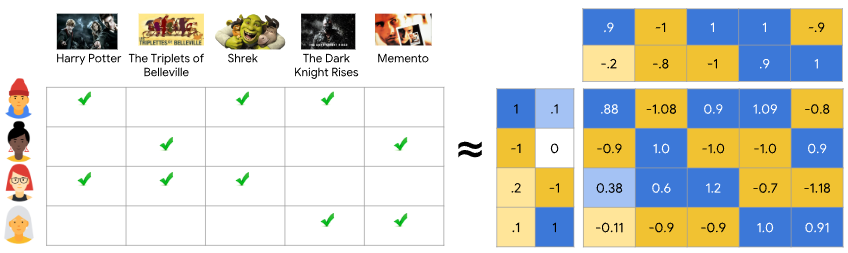


사용자 행렬: $N_{user}×Rank$ - 사용자 임베딩

아이템 행렬: $N_{item}×Rank$ - 아이템 임베딩

### 학습방법

#### ALS(Alternating Least Square):

$Interaction = U × I^T$

MovieLens 100K에서 상호 작용은 영화에 대한 사용자의 평점 입니다. 

> $Rating_{ij} = U_i \cdot I_j$

사용자의 관점에서, 평점은 영화의 임베딩 에 대한 선형 관계라고 할 수 있고,

> $Rating_{ij} = I_j \cdot U_i$

영화의 관점에서, 평점은 사용자의 임베딩에 대한 선형 관계라고 할 수 있습니다.

이러한 관계를 이용하면,

사용자의 임베딩은 아이템(영화)의 임베딩을 입력인 선형회귀모델의 학습을 통해 구할 수 있고.

아이템(영화)의 임베딩은 사용자의 임베딩을 입력인 선형회귀모델의 학습을 통해 구할 수 있습니다.


> (1) 사용자 / 아이템 임베딩 초기화
>
> (2-1) 사용자 임베딩 학습을 통해 업데이트
>
> (2-2) 아이템 임베딩 학습을 통해 업데이트
>
> (3) (2) 과정을 사용자의 임베딩과 아이템의 임베딩이 반복

In [7]:
# ALS를 Demo를 위한 위에서 보인 케이스만을 취합니다.
df_ratings_toy = df_ratings.loc[
    df_ratings['item id'].isin(item_index) &
    df_ratings['user id'].isin(user_index)
]
df_ratings_toy.shape

(53, 4)

1. 사용자 / 아이템 임베딩 초기화

$(0, \frac{1}{\sqrt{Rank}})$ 사이의 임의의 실수로 초기화합니다. (ALS 논문의 내용)

In [8]:
# 사용자와 아이템 행렬의 랭크를 3으로 합니다.
Rank = 3
# 동일한 결과를 얻기 위해 랜덤 시드값을 지정합니다.
np.random.seed(123)
# (0, 1/(Rank ** 0.5)) 사이의 난수를 사용자와 아이템의 임베딩 초기값으로 설정합니다.
df_user_emb = pd.DataFrame(
    (np.random.random(size=(len(user_index), Rank))) * 1 / np.sqrt(Rank), index=user_index
)
df_item_emb = pd.DataFrame(
    (np.random.random(size=(len(item_index), Rank))) * 1 / np.sqrt(Rank), index=item_index
)
df_user_emb.shape, df_item_emb.shape

((10, 3), (6, 3))

2. 사용자 / 아이템 임베딩 학습

정규방정식을 이용하여 선형회귀모델을 학습시켜 계수를 구하여 임베딩을 업데이트 합니다.

$\hat{\beta} = (X^T X)^{-1} X^T y$

In [9]:
# 입력 Matrix와 대상 변수에 대한 선형회귀 모델의 계수를 반환합니다.
def lr_coef(X, y):
    return np.dot(
        np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, y)
    )

In [10]:
# item_id를 69인 경우의 계수를 구해봅니다.
lr_coef(
    df_user_emb.loc[
        df_ratings_toy.loc[
            df_ratings_toy['item id'] == 69, 'user id'
        ]
    ], df_ratings_toy.loc[df_ratings_toy['item id'] == 69, 'rating']
)

array([ 5.7793186 , -2.98077025,  9.99594272])

In [11]:
# item id 별로 평가한 user id 의 임베딩을 df_user_emb에서 가져와서 입력 변수를 만들어 rating을 예측하는 
# OLS를 이용하여 선형회귀모델의 계수를 만듭니다.
df_ratings_toy.groupby('item id').apply(
    lambda x: pd.Series(
        lr_coef(df_user_emb.loc[x['user id']], x['rating'])
    ), include_groups = False
)

,0,1,2
item id,,,
1,6.593251,-5.205982,11.547203
29,5.522431,-1.471823,2.790506
69,5.779319,-2.980770,9.995943
96,6.702058,-3.136439,8.957213
226,4.665782,-0.624460,7.610579
402,3.374478,-2.270883,11.992309


In [12]:
# 2-1 아이템 임베딩 학습

# OLS를 이용하여 아이템별 회귀계수를 구하여 df_item_emb_next 데이터프레임을 만듭니다.
df_item_emb_next = df_ratings_toy.groupby('item id').apply(
    lambda x: pd.Series(
        lr_coef(
            df_user_emb.loc[x['user id']], x['rating']
        )
    ), include_groups = False
)
# 변경의 정도를 파악하기 위해 업데이트한 아이템 임베딩과 이전 임베딩 간의 차이의 제곱을 구합니다.
item_emb_diff = np.sum(
    np.sum(
        np.square(df_item_emb - df_item_emb_next), axis=0
    ), axis=0)
# 업데이트 합니다.
df_item_emb = df_item_emb_next
df_item_emb

,0,1,2
item id,,,
1,6.593251,-5.205982,11.547203
29,5.522431,-1.471823,2.790506
69,5.779319,-2.980770,9.995943
96,6.702058,-3.136439,8.957213
226,4.665782,-0.624460,7.610579
402,3.374478,-2.270883,11.992309


In [13]:
item_emb_diff

np.float64(728.5732918746372)

In [14]:
# 2-2 사용자 임베딩 업데이트 합니다.

df_user_emb_next = df_ratings_toy.groupby('user id').apply(
    lambda x: pd.Series(
        lr_coef(
            df_item_emb.loc[x['item id']], x['rating']
        )
    ), include_groups = False
)

user_emb_diff = ((df_user_emb - df_user_emb_next) ** 2).sum().sum()
df_user_emb = df_user_emb_next
df_user_emb

,0,1,2
user id,,,
7,0.516061,0.634194,0.392124
13,0.393520,0.678048,0.356878
94,0.099894,-0.136134,0.233914
276,0.574649,0.098999,0.131147
279,0.384026,0.682809,0.361387
303,0.353320,0.133474,0.298755
405,0.449600,-0.317001,0.013785
416,0.194407,0.213311,0.395661
682,0.276504,0.114749,0.256512


In [15]:
user_emb_diff

np.float64(1.187136115311858)

In [16]:
emb_diff = item_emb_diff + user_emb_diff
emb_diff

np.float64(729.7604279899491)

3. 2의 과정을 반복

In [17]:
# 1~3을 종합
from sklearn.metrics import mean_squared_error

# Step 1
Rank = 3
np.random.seed(123)
df_user_emb = pd.DataFrame(np.random.random(size=(len(user_index), Rank)) * 1 / np.sqrt(Rank), index=user_index)
df_item_emb = pd.DataFrame(np.random.random(size=(len(item_index), Rank)) * 1 / np.sqrt(Rank), index=item_index)

# Step 3: 10회 반복
for epoch in range(10):
    # Step 2
    #OLS를 이용하여 아이템별 회귀계수를 구합니다.
    df_item_emb_next = df_ratings_toy.groupby('item id').apply(
        lambda x: pd.Series(
            lr_coef(df_user_emb.loc[x['user id']], x['rating'])
        ), include_groups = False
    )
    item_emb_diff = np.sum(np.square(df_item_emb - df_item_emb_next), axis=0)
    df_item_emb = df_item_emb_next

    # 사용자 임베딩 학습
    df_user_emb_next = df_ratings_toy.groupby('user id').apply(
    lambda x: pd.Series(
            lr_coef(df_item_emb.loc[x['item id']], x['rating'])
        ), include_groups = False
    )
    user_emb_diff = np.sum(np.square(df_user_emb - df_user_emb_next), axis=0)
    df_user_emb = df_user_emb_next
    
    X_user = df_ratings_toy['user id'].apply(lambda x: df_user_emb.loc[x])
    X_item = df_ratings_toy['item id'].apply(lambda x: df_item_emb.loc[x])
    mse = mean_squared_error(df_ratings_toy['rating'], (X_user * X_item).sum(axis=1))
    emb_diff = np.sum(item_emb_diff + user_emb_diff, axis=0)
    print(epoch + 1, emb_diff, mse)

1 729.7604279899491 0.12188710594513749
2 4.559589375251532 0.06496126547005279
3 2.283052279308551 0.04633799138334469
4 0.524825469136112 0.04293589042320531
5 0.1739958952083807 0.042005196082754985
6 0.08226187257949148 0.041586486248460085
7 0.04671048983239096 0.04135132138443564
8 0.02950262608902558 0.041204441576543446
9 0.019966814732783493 0.041106424251441336
10 0.014189444200552468 0.04103777818252157


In [18]:
# Index에 MetaData를 가져옵니다.
df_user_emb.index = df_user_emb.index.map(df_user[['age', 'gender', 'occupation']].astype('str').apply(lambda x: '/'.join(x), axis=1))
df_item_emb.index = df_item_emb.index.map(df_movie['movie title'])

In [19]:
df_user_emb

,0,1,2
user id,,,
57/M/administrator,0.454722,0.360233,0.362876
47/M/educator,0.341479,0.558217,0.359995
26/M/student,0.092114,-0.109913,0.238039
21/M/student,0.603429,0.332988,0.178285
33/M/programmer,0.465353,0.585146,0.266435
19/M/student,0.464728,0.371894,0.303228
22/F/healthcare,0.350740,-1.011812,-0.092194
20/F/student,0.224052,0.150768,0.357096
23/M/programmer,0.270347,0.220779,0.295905


In [20]:
df_item_emb

,0,1,2
item id,,,
Toy Story (1995),8.920902,-6.834619,10.771041
Batman Forever (1995),4.896305,-2.635868,4.299393
Forrest Gump (1994),5.861110,-2.707590,9.451070
Terminator 2: Judgment Day (1991),6.422984,-1.613685,8.022609
Die Hard 2 (1990),4.988968,-0.835978,7.543837
Ghost (1990),2.568718,-3.362181,13.855455


In [21]:
# 사용자별 아이템에 대한 평점 예측을 합니다.
df_ratings_toy_prd = df_user_emb.dot(df_item_emb.T)
df_ratings_toy_prd = df_ratings_toy_prd.sort_index().sort_index(axis=1)
df_ratings_toy_prd.clip(1, 5).sort_index().sort_index(axis=1)

item id,Batman Forever (1995),Die Hard 2 (1990),Forrest Gump (1994),Ghost (1990),Terminator 2: Judgment Day (1991),Toy Story (1995)
user id,,,,,,
19/M/student,2.598885,4.295124,4.582718,4.144746,4.817504,4.870125
20/F/student,2.234919,3.685626,4.279918,5.000000,4.060635,4.814602
21/M/student,2.843375,4.077067,4.320149,2.900688,4.768784,5.000000
22/F/healthcare,3.987955,1.900188,3.923967,3.025461,3.145909,5.000000
23/M/programmer,2.013967,3.396445,3.783372,4.052046,3.754096,4.090000
26/M/student,1.764157,2.347167,3.087213,3.904301,2.678706,4.136879
27/M/lawyer,1.975786,3.949472,5.000000,5.000000,4.048140,5.000000
33/M/programmer,1.881650,3.842404,3.661245,2.919574,4.182216,3.021898
47/M/educator,1.748359,3.952714,3.892360,3.988228,4.180627,3.108620


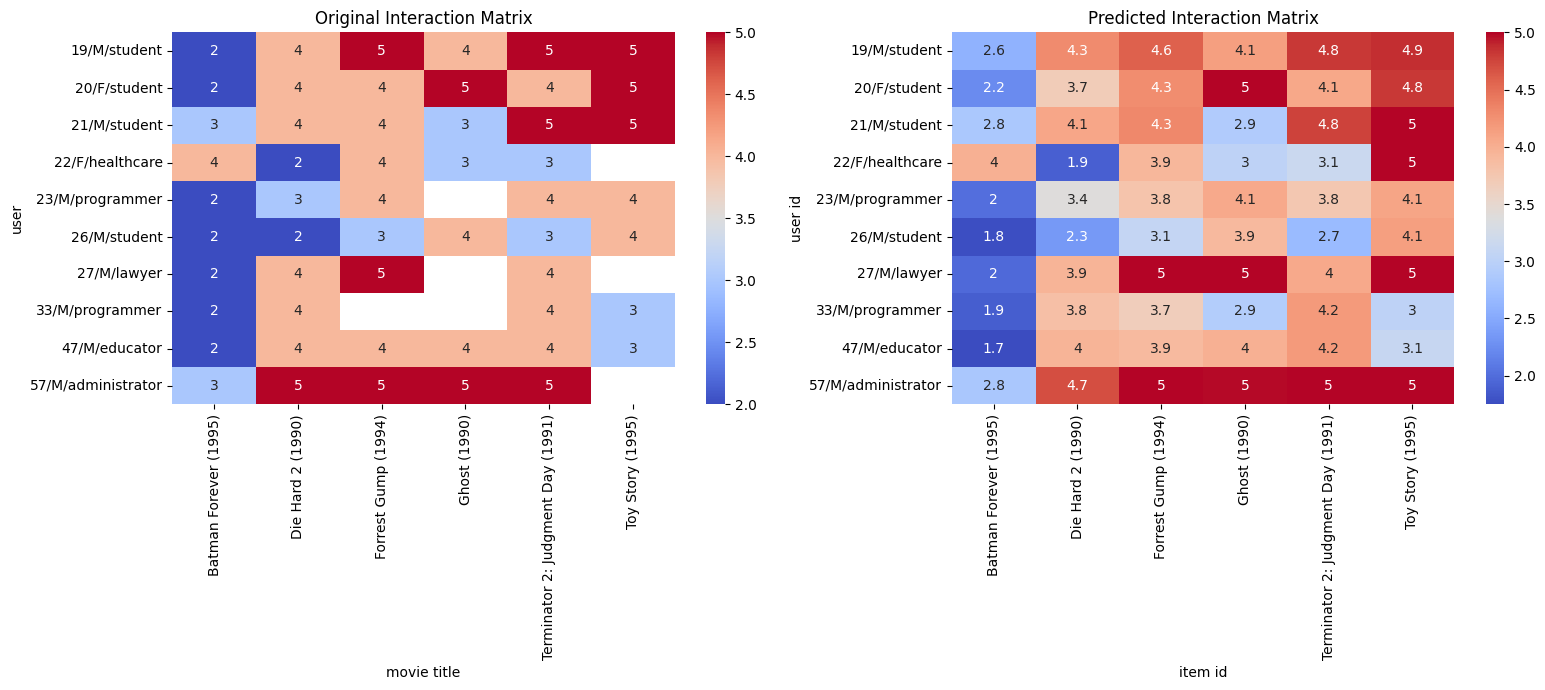

In [22]:
# 원래 상호작용행렬과 예측한 상호작용행렬을 Heatmap으로 표시합니다.
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

sns.heatmap(
    df_interaction,
    annot=True, cmap=cmap_coolwarm,
    ax=axes[0]
)
axes[0].set_title('Original Interaction Matrix')

sns.heatmap(
    df_ratings_toy_prd.clip(1, 5),
    annot=True, cmap=cmap_coolwarm,
    ax=axes[1]
)
axes[1].set_title('Predicted Interaction Matrix')

plt.tight_layout()
plt.show()

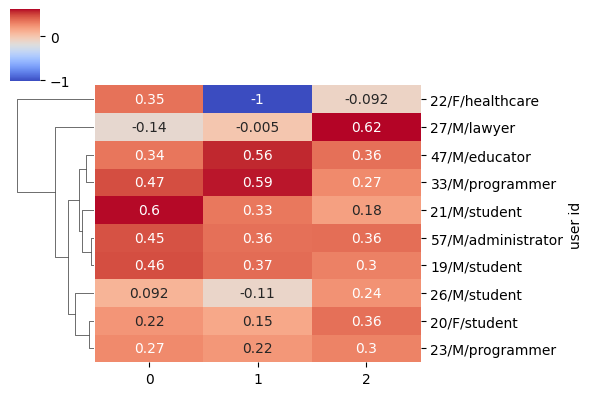

In [23]:
sns.clustermap(
    df_user_emb,
    annot=True, cmap=cmap_coolwarm,
    col_cluster=False,
    figsize=(6,4),
)
plt.show()

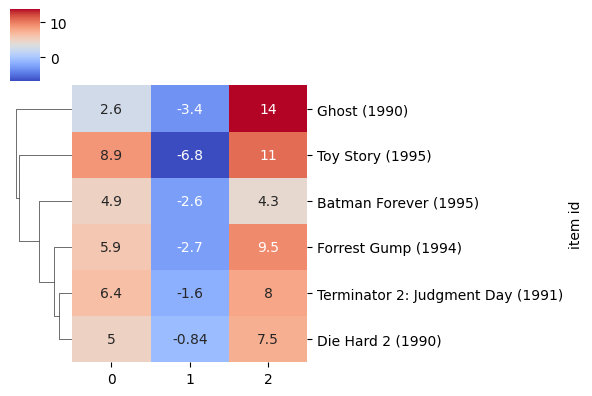

In [24]:
sns.clustermap(
    df_item_emb,
    annot=True, cmap=cmap_coolwarm,
    col_cluster=False,
    figsize=(6, 4),
)
plt.show()

#### 경사하강법(Gradient Descent)

$\hat{y} = User × Item^T$

$Loss(MSE) = \frac{1}{n}\sum_{i=1}^{n}{\left(y_i - \hat{y}_i\right)^2}$

$\nabla_{User_u} Loss = -\frac{2}{n_u}\sum_{j∈u's Rating}{\left(y_{j} - \hat{y}_{j}\right)Item_j}$

$\nabla_{Item_i} Loss = -\frac{2}{n_i}\sum_{j∈i's Rating}{\left(y_{j} - \hat{y}_{j}\right)User_j}$

> (1) 사용자 / 아이템 임베딩 초기화
>
> (2-1) 경사 계산
>
> (2-2) 임베딩 업데이트
>
>(3) (2)과정 반복

In [25]:
# Step 1: 임베딩을 초기화 합니다.
Rank = 3 # 랭크는 3으로 합니다.
learning_rate = 0.1 # 학습율은 0.1로 합니다.

np.random.seed(123)
df_user_emb = pd.DataFrame(
    np.random.random(size=(len(user_index), Rank)) * 1 / np.sqrt(Rank), index=user_index
)
df_item_emb = pd.DataFrame(
    np.random.random(size=(len(item_index), Rank)) * 1 / np.sqrt(Rank), index=item_index
)

In [26]:
# Step 2-1: 경사(기울기)를 계산합니다.

# df_ratings_toy에서 user id의 임베딩을 가져와서 X_user를 만듭니다.
X_user = df_ratings_toy['user id'].apply(lambda x: df_user_emb.loc[x])
# df_ratings_toy에서 user id의 임베딩을 가져와서 X_item을 만듭니다.
X_item = df_ratings_toy['item id'].apply(lambda x: df_item_emb.loc[x])
# 예측값을 구합니다.
y_hat = (X_user * X_item).sum(axis = 1)
err = df_ratings_toy['rating'] - y_hat

# 사용자별 경사도를 구합니다.
X_user_g = -2 * X_item.groupby(df_ratings_toy['user id']).apply(lambda x: err.loc[x.index].dot(x) / len(x))
# 아이템별 경사도를 구합니다.
X_item_g = -2 * X_item.groupby(df_ratings_toy['item id']).apply(lambda x: err.loc[x.index].dot(x) / len(x))
X_user_g

,0,1,2
user id,,,
7,-2.008783,-2.794230,-2.959924
13,-1.371189,-2.062402,-2.135029
94,-1.081527,-1.775121,-1.800544
276,-1.415214,-2.337855,-2.611399
279,-1.224017,-2.072096,-2.268044
303,-1.608441,-2.576141,-2.750129
405,-1.305145,-1.943331,-2.439146
416,-1.517698,-2.368360,-2.328011
682,-1.144955,-1.979064,-2.536480


In [27]:
# Step 2-2: 계산한 경사로 임베딩을 업데이트 합니다.

df_user_emb -= X_user_g * learning_rate
df_item_emb -= X_item_g * learning_rate

* 1~3 과정을 통합하여 루틴을 구성합니다.

In [28]:
# Step 1
Rank = 3
learning_rate = 0.1

np.random.seed(123)
df_user_emb = pd.DataFrame(np.random.random(size=(len(user_index), Rank)) * 1 / np.sqrt(Rank), index=user_index)
df_item_emb = pd.DataFrame(np.random.random(size=(len(item_index), Rank)) * 1 / np.sqrt(Rank), index=item_index)

# Step 3
for epoch in range(500):
    # Step 2-1

    X_user = df_ratings_toy['user id'].apply(lambda x: df_user_emb.loc[x])
    X_item = df_ratings_toy['item id'].apply(lambda x: df_item_emb.loc[x])
    y_hat = (X_user * X_item).sum(axis=1)
    err = df_ratings_toy['rating'] - y_hat

    X_user_g = -X_item.groupby(df_ratings_toy['user id']).apply(lambda x: err.loc[x.index].dot(x) / len(x))
    X_item_g = -X_user.groupby(df_ratings_toy['item id']).apply(lambda x: err.loc[x.index].dot(x) / len(x))
    
    # Step 2-2

    df_user_emb -= X_user_g * learning_rate
    df_item_emb -= X_item_g * learning_rate
    
    mse = mean_squared_error(df_ratings_toy['rating'], (X_user * X_item).sum(axis=1))
    if epoch % 50 == 0:
        print(epoch + 1, 'Loss(MSE): {}'.format(mse))
    if epoch % 10 == 9:
        learning_rate = learning_rate * 0.98
print(epoch + 1, 'Loss(MSE): {}'.format(mse))

1 Loss(MSE): 12.87593584638023
51 Loss(MSE): 0.26263566995205306
101 Loss(MSE): 0.16473693461473332
151 Loss(MSE): 0.12231488711654519
201 Loss(MSE): 0.08632047708925139
251 Loss(MSE): 0.0692537001002346
301 Loss(MSE): 0.061394371675077865
351 Loss(MSE): 0.05691636415092814
401 Loss(MSE): 0.05402317550440532
451 Loss(MSE): 0.05197788324348717
500 Loss(MSE): 0.05047301307009312


In [29]:
df_user_emb.index = df_user_emb.index.map(df_user[['age', 'gender', 'occupation']].astype('str').apply(lambda x: '/'.join(x), axis=1))
df_item_emb.index = df_item_emb.index.map(df_movie['movie title'])

In [30]:
df_ratings_toy_prd = df_user_emb.dot(df_item_emb.T)
df_ratings_toy_prd = df_ratings_toy_prd.sort_index().sort_index(axis=1)

In [31]:
df_ratings_toy_prd = df_user_emb.dot(df_item_emb.T)
df_ratings_toy_prd = df_ratings_toy_prd.sort_index().sort_index(axis=1)
df_ratings_toy_prd.clip(1, 5).sort_index().sort_index(axis=1)

,Batman Forever (1995),Die Hard 2 (1990),Forrest Gump (1994),Ghost (1990),Terminator 2: Judgment Day (1991),Toy Story (1995)
user id,,,,,,
19/M/student,2.551243,4.271667,4.690381,4.024728,4.922013,4.834439
20/F/student,2.373378,3.718609,4.391147,4.983615,3.976944,4.710973
21/M/student,2.702867,3.902554,4.383389,2.915147,4.862112,5.000000
22/F/healthcare,3.899801,1.930869,3.872258,3.065928,3.168245,5.000000
23/M/programmer,2.131079,3.303541,3.702181,3.010294,3.905205,4.048660
26/M/student,1.990041,2.361241,3.169064,3.870046,2.567020,4.069679
27/M/lawyer,2.176892,4.113516,4.601781,5.000000,4.193215,4.294392
33/M/programmer,1.648056,4.036417,4.186132,5.000000,3.977863,3.172108
47/M/educator,1.679950,3.901831,3.969518,4.051270,4.101358,3.134665


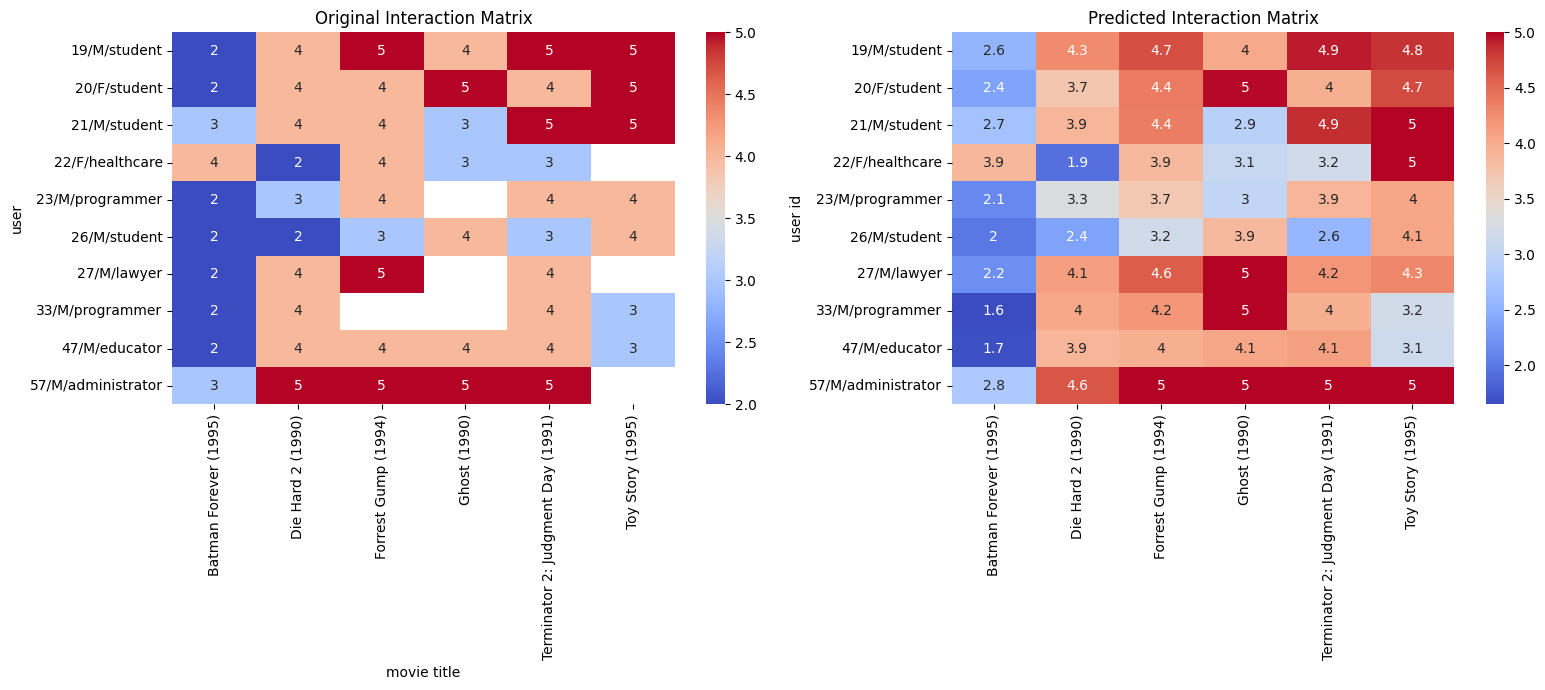

In [32]:
# 원래 상호작용행렬과 예측한 상호작용행렬을 Heatmap을 사용하여 표시합니다.
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

sns.heatmap(
    df_interaction,
    annot=True, cmap=cmap_coolwarm,
    ax=axes[0]
)
axes[0].set_title('Original Interaction Matrix')

sns.heatmap(
    df_ratings_toy_prd.clip(1, 5),
    annot=True, cmap=cmap_coolwarm,
    ax=axes[1]
)
axes[1].set_title('Predicted Interaction Matrix')

plt.tight_layout()
plt.show()

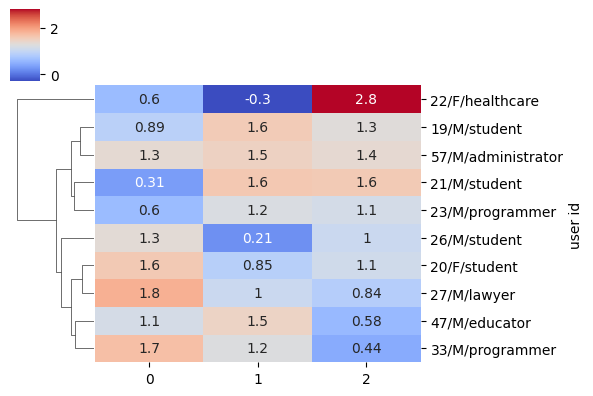

In [33]:
sns.clustermap(
    df_user_emb, annot=True, cmap=cmap_coolwarm, col_cluster=False, figsize=(6,4),
)
plt.show()

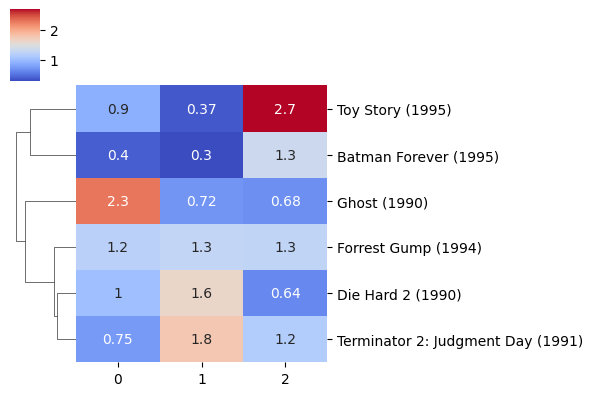

In [34]:
sns.clustermap(
    df_item_emb, annot=True, cmap=cmap_coolwarm, col_cluster=False, figsize=(6, 4),
)
plt.show()

## Tensorflow로 Matrix Factorization 모델 만들기: MovieLens 100K


Netflix Competition에서 1위 팀이 사용한 모델의 핵심 부분입니다.

[Matrix Factorization Techniques For Recommender](https://datajobs.com/data-science-repo/Recommender-Systems-[Netflix].pdf)

$\hat{r}_{ui} = \bar{r} + \bar{r_u} + \bar{r_i} + ue_u \cdot ie_i$

$\bar{r_u}$: 사용자의 상대적 평균(다른 사용자에 비해 평균적으로 평점을 얼마나 많이 주는지 나타냅니다.

$\bar{r_i}$: 아이템의 상대적 평균(다른 아이템에 비해 평균적으로 평점을 얼마나 많이 주는지 나타냅니다.

$ue_u \cdot ie_i$: 사용자와 아이템의 상호작용을 나타냅니다.

평균과 사용자의 평균 아이템의 평균과 함께 Matrix Factorization 모델을 사용하여,

Matrix Factorization 모델의 안정적으로 구성할 수 있었고, 

사용자와 아이템과 Rating과의 관계의 분석에 용이하게 됩니다.

ue: User Embedding, ie: Item Embedding

In [35]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorboard.plugins import projector
%load_ext tensorboard

In [36]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print("{} Physical GPUs, {} Logical GPUs".format(len(gpus), len(logical_gpus)))
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1766569281.951048   50935 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6094 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5


- 학습과 평가 데이터로 나눕니다.

In [37]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(
    df_ratings, train_size=0.8, random_state=123, shuffle=True
)

- Tensorflow Dataset으로 변환

In [38]:
# item_id와 user_id는 입력 변수이고 대상 변수는 rating은 Tensorflow Dataset을 만듭니다.
# Tensorflow 데이터셋을 사용하면 보다 안정적인 사용이 가능합니다.
# Tensorflow의 batch, shuffle 등 Dataset 처리를 활용할 수 있습니다.

ds_train = tf.data.Dataset.from_tensor_slices(
    ({i: df_train[i] for i in ['item id', 'user id']}, df_train['rating'])
)

ds_test = tf.data.Dataset.from_tensor_slices(
    ({i: df_test[i] for i in ['item id', 'user id']}, df_test['rating'])
)

In [39]:
# Tensorflow 데이터셋의 내용을 살펴 봅니다.

# batch_size 32개가 되도록하고, 첫 번째 배치만 출력합니다, 
for X, y in ds_train.batch(32).take(1):
    print(X, y)

{'item id': <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([  24,  511,  746,  196,   83,  632,  478,  387,  208, 1111,  654,
        400,  752,  425,  161,   69,  653,  117,  393,  183,  357,  281,
        118,  975,  529,  216,  100,  234,  354,   79,  313,   12])>, 'user id': <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([429, 480, 916, 892,  90, 144, 465, 301, 437, 758, 292, 254, 782,
       406, 851, 663, 303, 320, 291, 767,  16, 406, 213, 560, 325, 327,
       383, 833, 695, 454, 332, 543])>} tf.Tensor([3 4 3 4 5 4 4 3 5 4 5 3 4 3 3 4 4 4 3 4 5 3 4 3 4 3 4 3 4 4 5 5], shape=(32,), dtype=int64)


## Modeling

$\Large \displaystyle \hat{r}_{ui} = \bar{r} + \bar{r_u} + \bar{r_i} + ue_u \cdot ie_i$ 

Matrix Factorization(행렬 요인화) 부분과 평균화(Mean Encoding) 부분으로 나눕니다.

#### Matrix Factorization 부분

$\Large \displaystyle ue_u \cdot ie_i$

**모델 구조**

```mermaid
flowchart LR

    subgraph i[inputs]
        uId[user id]
        mId[item id]
    end

    subgraph mf["ue(u)·ie(i)"]
        direction LR
        subgraph lu["<div style='white-space:nowrap;'>lu_user_ids: IntegerLookup</div>"]
            vu[vocab: user id 리스트]
        end
        subgraph li["<div style='white-space:nowrap;'>lu_movie_ids: IntegerLookup</div>"]
            vi[vocab: item id 리스트]
        end
        subgraph emb_u["<div style='white-space:nowrap;'>emb_user: Embedding</div>"]
            param_1["(user id의 수+1)x8"]
        end
        subgraph emb_i["<div style='white-space:nowrap;'>emb_movie: Embedding</div>"]
            param_2["(item id의 수+1)x8"]
        end

        Rd["Dot(axis=-1)"]
        lu-->|N|emb_u
        li-->|N|emb_i

        emb_u-->|"ue: Nx8"| Rd
        emb_i-->|"ie: Nx8"| Rd
    end
    output((Rating))
    uId-->|N|lu
    mId-->|N|li
    Rd-->|N|output

    classDef layer fill:#E3F2FD,stroke:#1E88E5,stroke-width:1px,color:#0D47A1
    classDef trainable fill:#E8F5E9,stroke:#2E7D32,stroke-width:1px,color:#1B5E20
    classDef nontrainable fill:#FCE4EC,stroke:#C2185B,stroke-width:1px,color:#880E4F

    class lu layer
    class li layer
    class emb_u layer
    class emb_i layer
    class Rd layer
    
    class vu nontrainable
    class vi nontrainable
    class param_1 trainable
    class param_2 trainable
```

In [40]:
# IntegerLookup + Embedding 회상
voc = [100, 200, 300]
lu = tf.keras.layers.IntegerLookup(
    vocabulary = voc
)
emb_pos = lu(tf.constant([100, 200, 300, 400, 100]))
print(emb_pos)
emb = tf.keras.layers.Embedding(len(voc) + 1, 8)
emb_pos, emb(emb_pos)

tf.Tensor([1 2 3 0 1], shape=(5,), dtype=int64)


(<tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 2, 3, 0, 1])>,
 <tf.Tensor: shape=(5, 8), dtype=float32, numpy=
 array([[ 0.00942428,  0.01733167, -0.00060308,  0.02284415, -0.02494955,
         -0.02097678, -0.00744971, -0.03835138],
        [-0.01812829,  0.0083158 , -0.03633121,  0.02037236, -0.04993957,
          0.02432713, -0.04112219,  0.00034102],
        [ 0.02416838,  0.01163051, -0.04971978,  0.00721673,  0.02165243,
          0.04488934,  0.00040657,  0.03721792],
        [-0.03696962,  0.02469269, -0.01875933,  0.0202157 ,  0.02686382,
          0.00728936,  0.0032398 ,  0.00226822],
        [ 0.00942428,  0.01733167, -0.00060308,  0.02284415, -0.02494955,
         -0.02097678, -0.00744971, -0.03835138]], dtype=float32)>)

In [41]:
df_train['user id'].nunique() + 1

944

In [42]:
# 모델에서 사용하는 요소들을 Eager Execution 모드에서 제작합니다.
# 모델을 만드는 게 훨씬 수월해집니다.

# user id를 위치 Index로 바꿔주는 레이어입니다.
lu_userid = tf.keras.layers.IntegerLookup(
    vocabulary = tf.constant(df_train['user id'].unique())
)
# 사용자 임베딩 레이어입니다. 임베딩의 크기는 8입니다.
emb_user = tf.keras.layers.Embedding(df_train['user id'].nunique() + 1, 8)

# item id를 위치 Index로 바꿔주는 레이어입니다. 
lu_movieid = tf.keras.layers.IntegerLookup(
    vocabulary = tf.constant(df_train['item id'].unique())
)
# 아이템 임베딩 레이어입니다.
emb_movie = tf.keras.layers.Embedding(df_train['item id'].nunique() + 1, 8)

# Row-wise (axes=-1) Dot Product 레이어입니다.
dot = tf.keras.layers.Dot(axes=-1)

# user id를 임베딩에서의 위치 인덱스로 가져옵니다.
uid = lu_userid(tf.constant([1, 2, 0, -1, 5]))
print(uid)
# item id를 임베딩에서의 위치 인덱스로 가져옵니다.
mid = lu_movieid(tf.constant([3, 4, 5, 6, 7]))
print(mid)
# 위치 인덱스에 해당하는 사용자 임베딩을 가져옵니다.
x_uid = emb_user(uid)
# 위치 인덱스에 해당하는 영화 임베딩을 가져옵니다.
x_mid = emb_movie(mid)

# 결과를 출력합니다.
x_uid, x_mid, dot([x_uid, x_mid])

tf.Tensor([ 52 116   0   0 431], shape=(5,), dtype=int64)
tf.Tensor([728 394 393 737 131], shape=(5,), dtype=int64)


(<tf.Tensor: shape=(5, 8), dtype=float32, numpy=
 array([[ 0.03031219, -0.01092316, -0.02300303,  0.03882498,  0.03152846,
          0.01778123, -0.0073484 , -0.03016049],
        [ 0.04711241,  0.02708874, -0.00563389, -0.0015703 ,  0.00075927,
          0.04770941,  0.03139532,  0.03988426],
        [-0.01282916, -0.04623903, -0.0400241 ,  0.02192283, -0.04431754,
          0.01478547, -0.02848668,  0.03073957],
        [-0.01282916, -0.04623903, -0.0400241 ,  0.02192283, -0.04431754,
          0.01478547, -0.02848668,  0.03073957],
        [-0.048347  ,  0.0142459 , -0.01145439, -0.04018893, -0.02561971,
         -0.03911257,  0.01765184, -0.04272332]], dtype=float32)>,
 <tf.Tensor: shape=(5, 8), dtype=float32, numpy=
 array([[-0.02547977,  0.04013208,  0.00020608,  0.01566705,  0.02550944,
          0.02738135,  0.04945389, -0.04486714],
        [ 0.04130724,  0.00185317, -0.04931819,  0.00040253, -0.02338387,
         -0.03405825, -0.01180993,  0.03589097],
        [-0.00146788,  

### 평균화 부분

$\Large \displaystyle \bar{r} + \bar{ur_u} + \bar{ir_i}$

**모델 구조**

```mermaid
flowchart LR

    subgraph i[inputs]
        uId[user id]
        mId[item id]
    end

    subgraph mf["r+ur(u)+ir(i)"]
        direction LR
        subgraph lu["<div style='white-space:nowrap;'>lu_user_ids: IntegerLookup</div>"]
            vu[vocab: user id 리스트]
        end
        subgraph li["<div style='white-space:nowrap;'>lu_movie_ids: IntegerLookup</div>"]
            vi[vocab: item id 리스트]
        end
        subgraph emb_mu["<div style='white-space:nowrap;'>emb_user_mearn: Embedding</div>"]
            param_1["(user id의 수+1)x1"]
        end
        subgraph emb_mi["<div style='white-space:nowrap;'>emb_movie_mearn: Embedding</div>"]
            param_2["(item id의 수+1)x1"]
        end
        Rd("+")
        lu-->|N|emb_mu
        li-->|N|emb_mi

        emb_mu-->|"ur: Nx8"| Rd
        emb_mi-->|"ir: Nx8"| Rd
        r-->Rd
    end
    output((Rating))
    uId-->|N|lu
    mId-->|N|li
    Rd-->|N|output

    classDef layer fill:#E3F2FD,stroke:#1E88E5,stroke-width:1px,color:#0D47A1
    classDef trainable fill:#E8F5E9,stroke:#2E7D32,stroke-width:1px,color:#1B5E20
    classDef nontrainable fill:#FCE4EC,stroke:#C2185B,stroke-width:1px,color:#880E4F

    class lu layer
    class li layer
    class emb_mu layer
    class emb_mi layer
    class vu nontrainable
    class vi nontrainable
    class param_1 trainable
    class param_2 trainable
```

In [43]:
# 전체 평균을 구합니다.
mean = tf.constant([df_train['rating'].mean()], dtype=tf.float32)
lu_userid = tf.keras.layers.IntegerLookup(
    vocabulary = tf.constant(df_train['user id'].unique())
)
# 사용자의 평균을 저장하는 임베딩입니다.
emb_user_mean = tf.keras.layers.Embedding(
    df_train['user id'].nunique() + 1, 1
)

lu_movieid = tf.keras.layers.IntegerLookup(
    vocabulary = tf.constant(df_train['item id'].unique())
)
# 영화의 평균을 저장하는 임베딩입니다.
emb_movie_mean = tf.keras.layers.Embedding(
    df_train['item id'].nunique() + 1, 1
)

uid = lu_userid(tf.constant([1, 2, 0, 1, 5]))
mid = lu_movieid(tf.constant([3, 4, 5, 6, 7]))

x_uid = emb_user_mean(uid)
x_mid = emb_movie_mean(mid)

x_uid, x_mid, x_uid + x_mid + mean

(<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
 array([[-0.00699481],
        [-0.01334895],
        [-0.00738008],
        [-0.00699481],
        [ 0.00400281]], dtype=float32)>,
 <tf.Tensor: shape=(5, 1), dtype=float32, numpy=
 array([[ 0.04994842],
        [-0.03618199],
        [ 0.04846931],
        [-0.03209478],
        [ 0.04410155]], dtype=float32)>,
 <tf.Tensor: shape=(5, 1), dtype=float32, numpy=
 array([[3.5728161],
        [3.4803314],
        [3.5709517],
        [3.4907727],
        [3.5779667]], dtype=float32)>)

### Matrix Factorization augumented user/item mean Model

$\Large \displaystyle \hat{r}_{ui} = \bar{r} + \bar{ur_u} + \bar{ir_i} + ue_u \cdot ie_i$

**모델 구조**

```mermaid
flowchart LR
    subgraph i[inputs]
        uId[user id]
        mId[item id]
    end
    subgraph mf["<div style='white-space:nowrap;'>MF_Mean_Model(user_ids, item_ids, rating_mean, rank)</div>"]
        direction LR
        subgraph lu["<div style='white-space:nowrap;'>lu_user_ids: IntegerLookup</div>"]
            vu[vocab: user_ids]
        end
        subgraph li["<div style='white-space:nowrap;'>lu_movie_ids: IntegerLookup</div>"]
            vi[vocab: item_ids]
        end
        subgraph emb_u["<div style='white-space:nowrap;'>emb_user: Embedding</div>"]
            param_1["(user_ids 수+1)xrank"]
        end
        subgraph emb_i["<div style='white-space:nowrap;'>emb_movie: Embedding</div>"]
            param_2["(item_ids 수+1)xrank"]
        end
        subgraph emb_mu["<div style='white-space:nowrap;'>emb_user_mean: Embedding</div>"]
            param_3["(user_ids 수+1)x1"]
        end
        subgraph emb_mi["<div style='white-space:nowrap;'>emb_movie_mean: Embedding</div>"]
            param_4["(item_ids 수+1)x1"]
        end
        
        Rd["Dot(axis=-1)"]
        Ra("+")
        lu-->|N|emb_u
        lu-->|N|emb_mu
        li-->|N|emb_i
        li-->|N|emb_mi

        emb_u-->|"ue: Nxrank"| Rd
        emb_i-->|"ie: Nxrank"| Rd
        
        emb_mu-->|"ur: Nx1"| Ra
        emb_mi-->|"ir: Nx1"| Ra
        rating_mean-->Ra
        Rd-->|Nx1|Ra
    end
    output((Rating))
    uId-->|N|lu
    mId-->|N|li
    Ra-->|Nx1|output

    classDef layer fill:#E3F2FD,stroke:#1E88E5,stroke-width:1px,color:#0D47A1
    classDef trainable fill:#E8F5E9,stroke:#2E7D32,stroke-width:1px,color:#1B5E20
    classDef nontrainable fill:#FCE4EC,stroke:#C2185B,stroke-width:1px,color:#880E4F

    class lu layer
    class li layer
    class emb_u layer
    class emb_i layer
    class emb_mu layer
    class emb_mi layer
    class Rd layer
    
    class vu nontrainable
    class vi nontrainable
    class param_1 trainable
    class param_2 trainable
    class param_3 trainable
    class param_4 trainable
```

In [44]:
class MF_Mean_Model(tf.keras.Model):
    def __init__(self, user_ids, item_ids, rating_mean, rank):
        super().__init__()
        # user id들을 사전으로 구성하고 user id를 입력을 받아 이를 1부터 시작하는 인덱스로 변환해주는 Layer를 생성합니다. OOV: 0
        self.lu_user = tf.keras.layers.IntegerLookup(
            vocabulary = tf.constant(user_ids)
        )
        # item id들을 사전으로 구성하고 user id를 입력을 받아 이를 1부터 시작하는 인덱스로 변환해주는 Layer를 생성합니다. OOV: 0
        self.lu_item = tf.keras.layers.IntegerLookup(
            vocabulary = tf.constant(item_ids)
        )
        
        # user id에 대한 상대적 평균을 나타내는 임베딩입니다.
        self.emb_user_mean = tf.keras.layers.Embedding(len(user_ids) + 1, 1)
        # item id에 대한 상대적 평균을 나타내는 임베딩입니다. 
        self.emb_item_mean = tf.keras.layers.Embedding(len(item_ids) + 1, 1)
        
        # 사용자 행렬을 나타내는 사용자 임베딩입니다. 사이즈는 rank 입니다
        self.emb_user = tf.keras.layers.Embedding(len(user_ids) + 1, rank)
        # 영화 행렬을 나타내는 사용자 임베딩입니다.
        self.emb_item = tf.keras.layers.Embedding(len(item_ids) + 1, rank)

        # 점수의 평균입니다. 상수 텐서로 상수인 float32 텐서로 저장합니다.
        self.rating_mean = rating_mean
        
        # 맵핑된 사용자 임베딩과 맵핑된 아이템 임베딩을 Row-wise inner product 연산을 해주는 layer입니다. 
        self.dot = tf.keras.layers.Dot(axes=-1)

    def build(self):   
        # 1. 각 Lookup 레이어 build
        #   user id, item id는 모두 정수형이므로 동일한 shape로 처리
        self.lu_user.build((None, 1))
        self.lu_item.build((None, 1))
    
        # 2. Lookup 후 Embedding 레이어 shape 계산
        user_lu_shape = self.lu_user.compute_output_shape((None, 1))
        item_lu_shape = self.lu_item.compute_output_shape((None, 1))
    
        # 3. Embedding 레이어 build
        self.emb_user_mean.build(user_lu_shape)
        self.emb_item_mean.build(item_lu_shape)
        self.emb_user.build(user_lu_shape)
        self.emb_item.build(item_lu_shape)
    
        # 4. Dot layer build
        # Dot([user_vec, item_vec])의 입력 shape = (batch, rank)
        user_vec_shape = self.emb_user.compute_output_shape(user_lu_shape)
        item_vec_shape = self.emb_item.compute_output_shape(item_lu_shape)
        self.dot.build([user_vec_shape, item_vec_shape])

    def call(self, X, training=False):
        x_user = self.lu_user(X['user id'])# 사용자 ID에서 임베딩의 위치 인덱스로 변환합니다. X['user id'] N×1 정수 / x_user: N×1 정수
        user_vec = self.emb_user(x_user) #사용자 임베딩을 가져옵니다. user_vec: N×rank 실수
        user_mean = self.emb_user_mean(x_user) # 사용자의 상대적 평균을 가져옵니다. user_mean: N×1 실수
        
        x_item = self.lu_item(X['item id']) # 아이템 ID에서 임베딩 인덱스로 변환합니다. X['item id'] N×1 정수 / x_movie: N×1 정수
        item_vec =  self.emb_item(x_item) # 아이템 임베딩을 가져옵니다. user_vec: N×rank 실수
        item_mean = self.emb_item_mean(x_item) # 아이템의 상대적 평균을 가져옵니다.
        
        return user_mean + item_mean + self.dot([user_vec, item_vec]) + self.rating_mean
    
    def predict_by_userid(self, user_id, item_ids):
        """
            call에서의 연산은 (사용자1, 아이템1), (사용자2, 아이템2), ... 의 예측 연산입니다.
            실제 모델은 사용자 단위로 다수의 아이템에 대한 예측을 하게 됩니다.
            이러한 상황을 고려한 더욱 최적화한 루틴으로,
            한명의 사용자에게 여러 개의 아이템의 평점을 예측합니다.
        """
        
        x_user = self.lu_user(tf.constant([user_id])) # 사용자 ID에서 임베딩 인덱스로 변환합니다. X['user id'] (1) / x_user (1)
        user_vec = self.emb_user(x_user) # 사용자 임베딩을 가져옵니다. emb_user: 1×rank개의 실수
        # item id 별로 user id의 임베딩을 가져오는 작업과, item id 별로 반복되는 user_emb를 만들 필요가 없고 단일 벡터와 
        # item id 행렬의 곱의 연산이 되므로 계산량이 줄어 들게 됩니다.
        x_item = self.lu_item(item_ids) # 아이템 ID에서 임베딩 인덱스로 변환합니다. X['item id'] N개의 정수 / x_item: N개의 정수
        item_vec = self.emb_item(x_item)
        return tf.squeeze(
            tf.matmul(item_vec, user_vec, transpose_b=True) + 
            self.emb_item_mean(x_item) +
            self.emb_user_mean(x_user) + 
            self.rating_mean
        )

    def get_user_vec(self, user_id):
        x_user = self.lu_user(
            tf.constant([user_id])
        ) # 사용자 ID에서 임베딩 인덱스로 변환합니다. X['user id'] (1) / x_user (1)
        return tf.concat([
            tf.squeeze(self.emb_user(x_user)), tf.constant([1.0])
        ], axis=-1) # 사용자 임베딩을 가져옵니다. emb_user: 1×rank개의 실수

    def get_item_vecs(self, item_ids):
        x_item = self.lu_item(
            tf.constant(item_ids)
        )
        return tf.concat([
            self.emb_item(x_item), self.emb_item_mean(x_item)
        ], axis=-1)

In [45]:
# ds_train dataset에서 크기 32인 배치(Batch)로 나뉘도록 하고 하나의 배치셋만 출력해봅니다.
for X, y in ds_train.batch(32).take(1):
    print(X, y)

{'item id': <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([  24,  511,  746,  196,   83,  632,  478,  387,  208, 1111,  654,
        400,  752,  425,  161,   69,  653,  117,  393,  183,  357,  281,
        118,  975,  529,  216,  100,  234,  354,   79,  313,   12])>, 'user id': <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([429, 480, 916, 892,  90, 144, 465, 301, 437, 758, 292, 254, 782,
       406, 851, 663, 303, 320, 291, 767,  16, 406, 213, 560, 325, 327,
       383, 833, 695, 454, 332, 543])>} tf.Tensor([3 4 3 4 5 4 4 3 5 4 5 3 4 3 3 4 4 4 3 4 5 3 4 3 4 3 4 3 4 4 5 5], shape=(32,), dtype=int64)


In [46]:
mf_mean_model = MF_Mean_Model(
    df_train['user id'].value_counts().pipe(lambda x: x.loc[x > 20]).index.tolist(), # train에서 20회 넘게 등장한 사용자 ID를 전달합니다. 
    df_train['item id'].value_counts().pipe(lambda x: x.loc[x > 20]).index.tolist(), # train에서 20회 넘게 등장한 아이템 ID를 전달합니다.
    df_train['rating'].mean(), 8
)

In [47]:
tf.keras.backend.clear_session()
mf_mean_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # Adam Optimizer를 사용합니다.
    loss=tf.keras.losses.MeanSquaredError(), # 손실은 MSE를 사용합니다.
    metrics=[tf.keras.metrics.MeanSquaredError()] # 지표는 MSE로 합니다.
)

In [48]:
# mf_mean_model을 ds_train 데이터셋으로 
# 100,000개 shuffle buffer ← 데이터가 입력 변수에 편향 되어 있을 경우 학습이 제대로 이루어지지 않습니다. 고루 섞일 수 있도록 shuffle buffer를 둡니다.
# 256개의 배치 사이스
# 20개의 epochs로 학습을 합니다.
# ds_test로 Epoch 마다 검증 하도록 합니다. (validation_data)
history = mf_mean_model.fit(ds_train.shuffle(100000).batch(256), validation_data=ds_test.batch(256), epochs=20)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 1.1866 - mean_squared_error: 1.1866 - val_loss: 1.1463 - val_mean_squared_error: 1.1463
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1.0604 - mean_squared_error: 1.0604 - val_loss: 1.0567 - val_mean_squared_error: 1.0567
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9749 - mean_squared_error: 0.9749 - val_loss: 0.9938 - val_mean_squared_error: 0.9938
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9132 - mean_squared_error: 0.9132 - val_loss: 0.9534 - val_mean_squared_error: 0.9534
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.8713 - mean_squared_error: 0.8713 - val_loss: 0.9280 - val_mean_squared_error: 0.9280
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.8418 - mean_squared_error: 0.8418 - val_loss: 0.9112 - val_mean_squared_error: 0.9112
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.8189 - mean_squared_error: 0.8189 - val_los

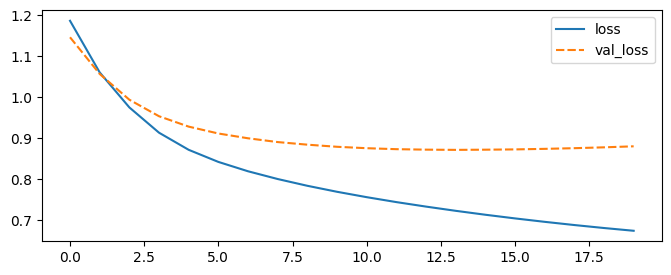

In [49]:
plt.figure(figsize = (8, 3))
pd.DataFrame(history.history).drop(
    columns = ['mean_squared_error', 'val_mean_squared_error']
).pipe(
    lambda x: sns.lineplot(x)
)
plt.show()

In [50]:
# 영화 임베딩을 3차원 공간에 투영하여 학습된 임베딩의 특성을 확인해봅니다.
import os

log_dir=os.path.join(log_path, 'm100k')
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# TSV로 만들면 영화 타이트을 투영시 보이게 할 수 있습니다.
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
    for i in df_train['item id'].value_counts().pipe(lambda x: x.loc[x > 20]).index:
        f.write("{}\n".format(df_movie.loc[i, 'movie title']))

# 영화의 임베딩을 기록합니다.
weights =  tf.Variable(mf_mean_model.emb_item.get_weights()[0][1:])
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# 프로젝터를 설정합니다.
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

WSL 환경에서

- multi_rcmd 컨테이너에 진입한 콘솔이 있다면 재사용 가능합니다.
```
docker exec -it multi_rcmd /bin/bash
```
- tensorboard 서버를 구동시킵니다.
```
tensorboard --logdir logs/m100k/ --host=0.0.0.0 --port=6006
```

## Matrix Factorization의 효율적 적용

**평점의 예측**

$\Large \displaystyle \hat{r}_{ui} = \bar{r} + \bar{ur_u} + \bar{ir_i} + ue_u \cdot ie_i$

In [51]:
# user id 1의 평점을 예측합니다.
prd = mf_mean_model({'user id': tf.constant([1] * len(df_movie), dtype = tf.int64), 'item id': tf.constant(df_movie.index, dtype = tf.int64)})
# 예측 평점 기준으로 상위 10개의 영화를 뽑아봅니다.
df_movie.iloc[np.argsort(-np.squeeze(prd))[:10], :2]

,movie title,release date
movie id,,
50,Star Wars (1977),01-Jan-1977
199,"Bridge on the River Kwai, The (1957)",01-Jan-1957
172,"Empire Strikes Back, The (1980)",01-Jan-1980
174,Raiders of the Lost Ark (1981),01-Jan-1981
173,"Princess Bride, The (1987)",01-Jan-1987
511,Lawrence of Arabia (1962),01-Jan-1962
654,Chinatown (1974),01-Jan-1974
483,Casablanca (1942),01-Jan-1942
100,Fargo (1996),14-Feb-1997


**개인별 평점의 예측**

$\Large \displaystyle \hat{r^{(u)}}_{i} = \bar{r} + \bar{ur_u} + \bar{ir_i} + ue_u \cdot ie_i$

```python
def predict_by_userid(self, user_id, item_ids):
    """
        call에서의 연산은 (사용자1, 아이템1), (사용자2, 아이템2), ... 의 예측 연산입니다.
        실제 모델은 사용자 단위로 다수의 아이템에 대한 예측을 하게 됩니다.
        이러한 상황을 고려한 더욱 최적화한 루틴으로,
        한명의 사용자에게 여러 개의 아이템의 평점을 예측합니다.
    """
    
    x_user = self.lu_user(tf.constant([user_id])) # 사용자 ID에서 임베딩 인덱스로 변환합니다. X['user id'] (1) / x_user (1)
    user_vec = self.emb_user(x_user) # 사용자 임베딩을 가져옵니다. emb_user: 1×rank개의 실수
    # item id 별로 user id의 임베딩을 가져오는 작업과, item id 별로 반복되는 user_emb를 만들 필요가 없고 단일 벡터와 
    # item id 행렬의 곱의 연산이 되므로 계산량이 줄어 들게 됩니다.
    x_item = self.lu_item(item_ids) # 아이템 ID에서 임베딩 인덱스로 변환합니다. X['item id'] N개의 정수 / x_item: N개의 정수
    item_vec = self.emb_item(x_item)
    return tf.squeeze(
        tf.matmul(item_vec, user_vec, transpose_b=True) + 
        self.emb_item_mean(x_item) +
        self.emb_user_mean(x_user) + 
        self.rating_mean
    )
```

In [52]:
# user id 1의 평점을 예측합니다.
prd = mf_mean_model.predict_by_userid(1, df_movie.index)
# 예측 평점 기준으로 상위 10개의 영화를 뽑아봅니다.
df_movie.iloc[np.argsort(-np.squeeze(prd))[:10], :2]

,movie title,release date
movie id,,
50,Star Wars (1977),01-Jan-1977
199,"Bridge on the River Kwai, The (1957)",01-Jan-1957
172,"Empire Strikes Back, The (1980)",01-Jan-1980
174,Raiders of the Lost Ark (1981),01-Jan-1981
173,"Princess Bride, The (1987)",01-Jan-1987
511,Lawrence of Arabia (1962),01-Jan-1962
654,Chinatown (1974),01-Jan-1974
483,Casablanca (1942),01-Jan-1942
100,Fargo (1996),14-Feb-1997


**추천 = Ranking**

개인별 아이템에 대한 평점 예측 → 개인별 아이템에 대한 **순위** 예측

**여기서 개인별 순위 예측에 있어 유의미한 요소로 간소화**

$\Large \displaystyle \cancel{\bar{r} + \bar{ur_u}} + \bar{ir_i} + ue_u \cdot ie_i$

$\hat{Ranking}^{(u)}_{i} = Rank(\bar{ir_i} + ue_u \cdot ie_i)$

```mermaid
flowchart LR
    subgraph i[inputs]
        uId[user id]
        mId[item id]
    end
    subgraph mf["<div style='white-space:nowrap;'>Rank(ir+ue(u)·ie(i))</div>"]
        direction LR
        subgraph lu["<div style='white-space:nowrap;'>lu_user_ids: IntegerLookup</div>"]
            vu[vocab: user_ids]
        end
        subgraph li["<div style='white-space:nowrap;'>lu_movie_ids: IntegerLookup</div>"]
            vi[vocab: item_ids]
        end
        subgraph emb_u["<div style='white-space:nowrap;'>emb_user: Embedding</div>"]
            param_1["(user_ids 수+1)xrank"]
        end
        subgraph emb_i["<div style='white-space:nowrap;'>emb_movie: Embedding</div>"]
            param_2["(item_ids 수+1)xrank"]
        end
        subgraph emb_mi["<div style='white-space:nowrap;'>emb_movie_mean: Embedding</div>"]
            param_4["(item_ids 수+1)x1"]
        end

        cc["concat(axis=-1)"]
        cc2["concat(axis=-1)"]
        
        Rd["Dot(axis=-1)"]
        Rank(Rank)
        
        lu-->|N|emb_u
        
        li-->|N|emb_i
        li-->|N|emb_mi
        
        emb_i-->|"ie: Nxrank"| cc
        emb_mi-->|"ir: Nx1"| cc
        cc-->|"Nx(rank+1)"| Rd

        emb_u-->|"ue: Nxrank"| cc2
        1-->|1| cc2
        cc2-->|"ie: Nx(rank+1)"| Rd
        
        
        Rd-->|Nx1|Rank
    end
    output((Ranking))
    uId-->|N|lu
    mId-->|N|li
    Rank-->|Nx1|output

    classDef layer fill:#E3F2FD,stroke:#1E88E5,stroke-width:1px,color:#0D47A1
    classDef trainable fill:#E8F5E9,stroke:#2E7D32,stroke-width:1px,color:#1B5E20
    classDef nontrainable fill:#FCE4EC,stroke:#C2185B,stroke-width:1px,color:#880E4F

    class lu layer
    class li layer
    class emb_u layer
    class emb_i layer
    class emb_mu layer
    class emb_mi layer
    class Rd layer
    
    class vu nontrainable
    class vi nontrainable
    class param_1 trainable
    class param_2 trainable
    class param_3 trainable
    class param_4 trainable
```

$\hat{Ranking}^{(u)}_{i} = Rank(\tilde{ue_u} \cdot \tilde{ie_i})$

Matrix Factorization 모델에의 한 랭킹의 문제는 **아이템의 벡터들**과 **사용자의 벡터** 와의 Dot Prodct 기반의 **유사도 기반**의 탐색이 된다.

### ANN(Approximate Nearest Neighbor) Index

벡터의 척도(Cosine 거리, Euclidean 거리, **Dot product**)를 기반으로 근거리의 벡터를 **탐색(Search)을 최적화**한 자료구조

**ANN 라이브러리**

| 항목 | ScaNN | FAISS | HNSW |
|------|-------|--------|--------|
| **개발사 / 개발 주체** | Google Research | Meta (Facebook AI Research) | 독립 연구(윤 체슬라브 Yury Malkov), 오픈소스 커뮤니티 |
| **공개 시점** | 2020년 | 2017년 | 2014~2018년 연구 발표 후 확산 |
| **개발 목적** | 대규모 검색·추천 시스템을 위한 고정밀·고속 ANN 라이브러리 | CPU/GPU 기반 초고속 벡터 검색 및 클러스터링 | 그래프 기반으로 높은 정확도와 빠른 근접 탐색 제공 |
| **장점 (Strength)** | - 매우 높은 recall/속도<br>- Google 내부 기술 기반<br>- 고차원 벡터에서 성능 우수<br>- 분할+해싱+재랭킹 결합 구조 | - 다양한 인덱스(IVF, HNSW, PQ 등) 지원<br>- GPU 가속이 매우 강력<br>- 대규모 데이터 처리에 최적<br>- 산업계 표준 라이브러리 | - 매우 빠른 검색 속도<br>- 높은 recall 가능<br>- 구조 단순, 안정성 높음<br>- 많은 벡터 DB에서 기본 인덱스로 채택 |
| **단점 (Limitations)** | - 튜닝 난이도 있음<br>- GPU 지원 약함(CPU 중심)<br>- Google Cloud 외 환경에서 설정 부담 | - 인덱스 조정이 복잡할 수 있음<br>- PQ 방식은 정확도 손실 가능<br>- GPU 사용 시 비용 증가 | - 메모리 사용량 큼<br>- 대규모 디스크 기반 환경에서 성능 저하 가능<br>- 인덱스 생성 시간이 길 수 있음 |
| **요약** | Google이 서비스 운영용으로 최적화한 고정밀·고성능 ANN 라이브러리 | CPU/GPU 모두 활용 가능한 ANN 표준 라이브러리로 유연성과 성능 모두 우수 | 그래프 기반 고성능 인덱스로 메모리 환경에서 최고의 속도와 recall 제공 |


### ANN을 통한 Matrix Factorization 모델의 추천 서비스 아키텍쳐

```mermaid
flowchart TD
    subgraph RCMD["추천 시스템"]
        subgraph MF[Matrix Factorization Model]
            IE["아이템들의 임베딩 계산<br/>get_item_vecs"]
            UE["유저 임베딩 계산<br/>get_user_vec"]
        end
        subgraph ANN["ANN 모듈"]
            BD["ANN 인덱스 빌드<br/>scann.scann_ops.builder"]
            SR["유사 아이템 탐색<br/>search"]
        end
        PR["추천 준비"]
        RC["개인화 추천"]
        PR -->|"1.아이템들의 임베딩 요청"| IE
        IE -->|"2.아이템들의 임베딩"| PR
        PR -->|"3.아이템들의 인덱스 빌드 요청"| BD
        RC -->|"1. 사용자 임베딩 요청"| UE
        UE -->|"2. 사용자 임베딩"| RC
        RC -->|"3. 유사 아이템 목록 요청"| SR
        SR -->|"4. 아이템 목록"| RC
    end
    OP[관리 시스템]-->|0.준비| PR
    BK[서비스 Back-end]-->|0.user id| RC
    RC-->|5.item id list| BK
```

**get_user_vec**

```mermaid
flowchart LR
    subgraph i[inputs]
        uId[user id]
    end
    subgraph mf["<div style='white-space:nowrap;'>get_user_vec(user_id)</div>"]
        direction LR
        subgraph lu["<div style='white-space:nowrap;'>lu_user_ids: IntegerLookup</div>"]
            vu[vocab: user_ids]
        end
        
        subgraph emb_u["<div style='white-space:nowrap;'>emb_user: Embedding</div>"]
            param_1["(user_ids 수+1)xrank"]
        end
        cc2["concat(axis=-1)"]
        sq(squeeze)

        lu-->|1|emb_u       
        
        emb_u-->|"ue: 1xrank"| cc2
        1-->|1| cc2
    end

    output((User Vector))
    uId-->|1|lu
    cc2-->|"ie: 1x(rank+1)"| sq
    sq-->|"rank+1"| output

    classDef layer fill:#E3F2FD,stroke:#1E88E5,stroke-width:1px,color:#0D47A1
    classDef trainable fill:#E8F5E9,stroke:#2E7D32,stroke-width:1px,color:#1B5E20
    classDef nontrainable fill:#FCE4EC,stroke:#C2185B,stroke-width:1px,color:#880E4F

    class lu layer
    class emb_u layer
    
    class vu nontrainable
    class param_1 trainable
```

```python
def get_user_vec(self, user_id):
        x_user = self.lu_user(
            tf.constant([user_id])
        ) # 사용자 ID에서 임베딩 인덱스로 변환합니다. X['user id'] (1) / x_user (1)
        return tf.concat([
            tf.squeeze(self.emb_user(x_user)), tf.constant([1.0])
        ], axis=-1) # 사용자 임베딩을 가져옵니다. emb_user: 1×rank개의 실수
```

In [53]:
mf_mean_model.get_user_vec(1)

<tf.Tensor: shape=(9,), dtype=float32, numpy=
array([ 0.6013767 , -0.14645532,  0.1486691 , -0.3218859 ,  0.5507624 ,
        0.58937675, -0.12940231, -0.35212216,  1.        ], dtype=float32)>

**get_item_vec**

```mermaid
flowchart LR
    subgraph i[inputs]
        mId[item id]
    end
    subgraph mf["<div style='white-space:nowrap;'>Rank(ir+ue(u)·ie(i))</div>"]
        direction LR
        subgraph li["<div style='white-space:nowrap;'>lu_movie_ids: IntegerLookup</div>"]
            vi[vocab: item_ids]
        end
        subgraph emb_i["<div style='white-space:nowrap;'>emb_movie: Embedding</div>"]
            param_2["(item_ids 수+1)xrank"]
        end
        subgraph emb_mi["<div style='white-space:nowrap;'>emb_movie_mean: Embedding</div>"]
            param_4["(item_ids 수+1)x1"]
        end
        
        cc["concat(axis=-1)"]
              
        li-->|N|emb_i
        li-->|N|emb_mi
        
        emb_i-->|"ie: Nxrank"| cc
        emb_mi-->|"ir: Nx1"| cc

    end
    output((Items Matrix))
    mId-->|N|li
    cc-->|"Nx(rank+1)"|output

    classDef layer fill:#E3F2FD,stroke:#1E88E5,stroke-width:1px,color:#0D47A1
    classDef trainable fill:#E8F5E9,stroke:#2E7D32,stroke-width:1px,color:#1B5E20
    classDef nontrainable fill:#FCE4EC,stroke:#C2185B,stroke-width:1px,color:#880E4F

    class li layer
    class emb_i layer
    class emb_mi layer
    
    class vi nontrainable
    class param_2 trainable
    class param_4 trainable
```

```python
def get_item_vecs(self, item_ids):
    x_item = self.lu_item(
        tf.constant(item_ids)
    )
    return tf.concat([
        self.emb_item(x_item), self.emb_item_mean(x_item)
    ], axis=-1)
```

In [54]:
mf_mean_model.get_item_vecs(df_movie.index.tolist())

<tf.Tensor: shape=(1682, 9), dtype=float32, numpy=
array([[ 0.9435228 , -0.00528802,  0.37058008, ...,  0.06641822,
         0.17650984,  0.2042472 ],
       [-0.14361414,  0.17243795,  0.12797931, ...,  0.46080706,
        -0.34285071, -0.07868885],
       [-0.24517314,  0.08980384,  0.42494813, ...,  0.35178432,
         0.27437884, -0.11812124],
       ...,
       [-0.3902339 ,  0.49849135,  0.11709205, ...,  0.44043228,
         0.5505958 , -0.1887397 ],
       [-0.3902339 ,  0.49849135,  0.11709205, ...,  0.44043228,
         0.5505958 , -0.1887397 ],
       [-0.3902339 ,  0.49849135,  0.11709205, ...,  0.44043228,
         0.5505958 , -0.1887397 ]], shape=(1682, 9), dtype=float32)>

**ANN 활용**

In [55]:
import scann

# 인덱스 빌드
scann_index = scann_index = scann.scann_ops.builder(
    mf_mean_model.get_item_vecs(df_movie.index.tolist()), # 아이템들의 임베딩 행렬 계산 
    1000, # 제공 받을 유사 아이템 수 
    'dot_product' # 유사도 척도를 dot product로 설정
).score_brute_force().build()

In [56]:
# 유사 임베딩 아이템 탐색
labels, sims = scann_index.search(
    mf_mean_model.get_user_vec(1) # 사용자(사용자 Id 1) 임베딩 계산
)
df_movie.iloc[labels[:10].numpy(), :2]

,movie title,release date
movie id,,
50,Star Wars (1977),01-Jan-1977
199,"Bridge on the River Kwai, The (1957)",01-Jan-1957
172,"Empire Strikes Back, The (1980)",01-Jan-1980
174,Raiders of the Lost Ark (1981),01-Jan-1981
173,"Princess Bride, The (1987)",01-Jan-1987
511,Lawrence of Arabia (1962),01-Jan-1962
654,Chinatown (1974),01-Jan-1974
483,Casablanca (1942),01-Jan-1942
100,Fargo (1996),14-Feb-1997


### 계산 효율성 비교

**predict**

$\hat{r^{(u)}}_{i} = \bar{r} + \bar{ur_u} + \bar{ir_i} + ue_u \cdot ie_i$

In [57]:
%%timeit
# 1번 사용자에 대해 모든 영화에 대한 평점 예측을 뽑는데 시간을 측정합니다.
# 모델으 호출 루틴은 user id, item id 를 건별로 입력 받게 되어 있습니다.
np.argsort(
    -mf_mean_model({'user id': tf.constant([1] * len(df_movie), dtype = tf.int64), 'item id': tf.constant(df_movie.index, dtype = tf.int64)})
)[:1000]

10.8 ms ± 157 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


**predict_by_user**
  
$\hat{r^{(u)}}_{i} = \bar{r} + \bar{ur_u} + \bar{ir_i} + ue_u \cdot ie_i$

In [58]:
%%timeit
# predict_by_userid 
np.argsort(
    -mf_mean_model.predict_by_userid(1, df_movie.index)
)[:1000]

10.6 ms ± 237 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


**ANN ranking**

$\hat{Ranking}^{(u)}_{i} = Rank(\tilde{ue_u} \cdot \tilde{ie_i})$

In [59]:
%%timeit
labels, sims = scann_index.search(mf_mean_model.get_user_vec(1))

4.06 ms ± 83.1 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# VS NNModel

### Neural Networks Architecture


```mermaid
flowchart LR

    subgraph i[inputs]
        uId[user id]
        mId[item id]
    end

    subgraph mf["<div style='white-space:nowrap;'>NNModel(user_ids, item_ids, emb_user_size, emb_item_size)</div>"]
        direction LR
        subgraph lu["<div style='white-space:nowrap;'>lu_user: IntegerLookup</div>"]
            vu[vocab: user_ids]
        end
        subgraph li["<div style='white-space:nowrap;'>lu_item: IntegerLookup</div>"]
            vi[vocab: item_ids]
        end
        subgraph emb_u["<div style='white-space:nowrap;'>emb_user: Embedding</div>"]
            param_1["(user id의 수+1)x<br/>emb_user_size"]
        end
        subgraph emb_i["<div style='white-space:nowrap;'>emb_item: Embedding</div>"]
            param_2["(item id의 수+1)x<br/>emb_item_size"]
        end

        subgraph cc["Concatenate"]
            a["<div style='white-space:nowrap;'>axis=-1<br/>M=emb_user_size+emb_item_size</div"]
        end
        lu-->|N|emb_u
        li-->|N|emb_i

        emb_u-->|"Nxemb_user_size"| cc
        emb_i-->|"Nxemb_item_size"| cc

        subgraph h1[dl1:Dense]
            param_3["unit_size:64<br/><br/>activation: ReLU"]
        end

        subgraph h2[dl2:Dense]
            param_4["unit_size:16<br/><br/>activation: ReLU"]
        end

        subgraph ol[o:Dense]
            param_5["unit_size:1<br/><br/>activation: None"]
        end
        cc-->|"NxM"|h1
        h1-->|Nx64|h2
        h2-->|Nx16|ol
    end
    output((Rating))
    uId-->|N|lu
    mId-->|N|li
    ol-->|Nx1|output

    classDef layer fill:#E3F2FD,stroke:#1E88E5,stroke-width:1px,color:#0D47A1
    classDef trainable fill:#E8F5E9,stroke:#2E7D32,stroke-width:1px,color:#1B5E20
    classDef nontrainable fill:#FCE4EC,stroke:#C2185B,stroke-width:1px,color:#880E4F

    class lu layer
    class li layer
    class emb_u layer
    class emb_i layer
    class cc layer
    class h1 layer
    class h2 layer
    class ol layer
    
    class vu nontrainable
    class vi nontrainable
    class param_1 trainable
    class param_2 trainable
```

In [60]:
class NNModel(tf.keras.Model):
    def __init__(self, user_ids, item_ids, emb_user_size, emb_item_size):
        """
        Parameters:
            user_ids: array_like
                사용자 ID 목록
            item_ids: array_like
                아이템 ID 목록
            emb_user_size: int
                사용자 임베딩 크기
            emb_item_size: int
                아이템 임베딩 크기
        """
        super().__init__()
        self.lu_user = tf.keras.layers.IntegerLookup(
            vocabulary = tf.constant(user_ids)
        )
        self.lu_item = tf.keras.layers.IntegerLookup(
            vocabulary = tf.constant(item_ids)
        )
        
        self.emb_user =  tf.keras.layers.Embedding(
            len(user_ids) + 1, emb_user_size
        )
        self.emb_item =  tf.keras.layers.Embedding(
            len(item_ids) + 1, emb_item_size
        )
        
        self.cc = tf.keras.layers.Concatenate(axis=-1)
        
        self.dl1 = tf.keras.layers.Dense(
            16, activation = 'relu', kernel_initializer = 'he_uniform'
        )
        self.dl2 = tf.keras.layers.Dense(8, activation = 'relu', kernel_initializer = 'he_uniform')
        self.o = tf.keras.layers.Dense(
            1, kernel_initializer = 'glorot_uniform'
        )

    def build(self):
        """
        입력: {'user id': (batch, 1), 'item id': (batch, 1)} 형태의 딕셔너리
        각 Lookup/Embedding/연산 Layer를 명시적으로 build하여 가중치 초기화 수행
        """
    
        # 1. 각 Lookup 레이어 build
        #   user id, item id는 모두 정수형이므로 동일한 shape로 처리
        self.lu_user.build((None, 1))
        self.lu_item.build((None, 1))
    
        # 2. Lookup 후 Embedding 레이어 shape 계산
        user_lu_shape = self.lu_user.compute_output_shape((None, 1))
        item_lu_shape = self.lu_item.compute_output_shape((None, 1))
    
        # 3. Embedding 레이어 build
        self.emb_user.build(user_lu_shape)
        self.emb_item.build(item_lu_shape)
    
        # 4. Dense layer build
        # Dot([user_vec, item_vec])의 입력 shape = (batch, rank)
        user_vec_shape = self.emb_user.compute_output_shape(user_lu_shape)
        item_vec_shape = self.emb_item.compute_output_shape(item_lu_shape)
        cc_shape = self.cc.compute_output_shape([user_vec_shape, item_vec_shape])
        dl1_shape = self.dl1.compute_output_shape(cc_shape)
        dl2_shape = self.dl2.compute_output_shape(dl1_shape)
        self.dl1.build(cc_shape)
        self.dl2.build(dl1_shape)

        self.o.build(dl2_shape)

    def call(self, x, training=False):
        x_user = self.lu_user(x['user id']) # 사용자 ID에서 임베딩의 위치 인덱스로 변환합니다. x['user id'] N×1 정수 / x_user: N×1 정수
        user_vec = self.emb_user(x_user) # 사용자 임베딩을 가져옵니다. user_vec: N×rank 실수
        x_item = self.lu_item(x['item id']) # 아이템 ID에서 임베딩 인덱스로 변환합니다. x['item id'] N×1 정수 / x_movie: N×1 정수
        item_vec = self.emb_item(x_item) # 아이템 임베딩을 가져옵니다. user_vec: N×rank 실수
        x = self.cc([user_vec, item_vec])
        x = self.dl1(x) # dense layer 1 
        x = self.dl2(x) # dense layer 2
        return self.o(x) # output layer

In [61]:
nn_model = NNModel(
    df_train['user id'].value_counts().pipe(lambda x: x.loc[x > 20]).index.tolist(), 
    df_train['item id'].value_counts().pipe(lambda x: x.loc[x > 20]).index.tolist(), 
    16, 10
)

In [62]:
tf.keras.backend.clear_session()
nn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanSquaredError()]
)
history = nn_model.fit(ds_train.shuffle(10000).batch(256), validation_data=ds_test.batch(1024), epochs=20)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 3.6761 - mean_squared_error: 3.6761 - val_loss: 0.9528 - val_mean_squared_error: 0.9528
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.9083 - mean_squared_error: 0.9083 - val_loss: 0.9311 - val_mean_squared_error: 0.9311
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.8961 - mean_squared_error: 0.8961 - val_loss: 0.9250 - val_mean_squared_error: 0.9250
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.8885 - mean_squared_error: 0.8885 - val_loss: 0.9201 - val_mean_squared_error: 0.9201
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.8785 - mean_squared_error: 0.8785 - val_loss: 0.9201 - val_mean_squared_error: 0.9201
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.8730 - mean_squared_error: 0.8730 - val_loss: 0.9164 - val_mean_squared_error: 0.9164
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.8670 - mean_squared_error: 0.8670 - val_los

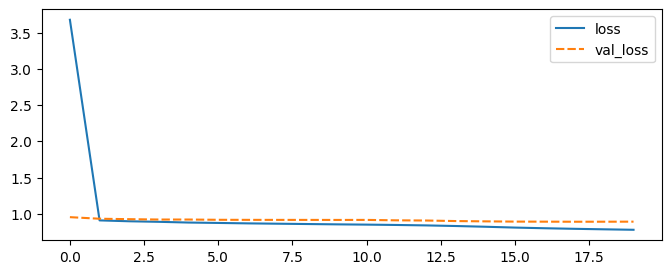

In [63]:
plt.figure(figsize = (8, 3))
pd.DataFrame(history.history).drop(
    columns = ['mean_squared_error', 'val_mean_squared_error']
).pipe(
    lambda x: sns.lineplot(x)
)
plt.show()

**MF 와 NN 모델의 구조 비교**


```mermaid
flowchart TD

    %% MF 구조 %%
    subgraph MF["Matrix Factorization 모델"]
        direction TB
        U["User ID"] --> UE["User Embedding (K)"]
        I["Item ID"] --> IE["Item Embedding (K)"]
        UE --> DOT["내적 연산 (u·v)"]
        IE --> DOT
        DOT --> PRED_MF["예측 점수 (선형 결합)"]
    end

    %% Neural Network 구조 %%
    subgraph NN["Neural Network 기반 모델"]
        direction TB
        U2["User ID"] --> UE2["User Embedding (U)"]
        I2["Item ID"] --> IE2["Item Embedding (K)"]
        FN["Feature 1,...,N"] -->CONCAT

        UE2 --> CONCAT["벡터 결합"]
        IE2 --> CONCAT

        CONCAT --> H1["Hidden Layers 1, ..., N"]
        H1 --> PRED_NN["예측 점수"]
    end
```

**MF 모델의 구조적 한계점: 표현력에 한계** 

- 본질적인 한계점

> User Embedding과 Item Embedding의 사이즈가 같다
> 
> 최종적으로 내적에 의한 출력 모델이 만들어진다.

- 개선이 일부 가능한 한계점

> 은닉층을 통한 비선형 패턴의 표현
> 
> 다양한 속성 반영

--> 신경망 모델과 혼합을 통해 완화가 가능 (Hybrid Matrix Factorization, Two-tower model)

**NN 모델이 지니는 구조적 한계점: 연산 속도**


# MF + NN

## [Youtube Recommender](https://github.com/Dryjelly/Youtube_Recommendation_tf_keras)

논문의 골자: 

Matrix Factorization은 추천 아이템을 1차적으로 후보 대상을 선정하여 예측 대상을 줄이고,

Nerual Network을 통해 정교한 예측 결과로 순위를 메기는 구조로

추천 시스템을 구성한다는 것입니다.

[Tensorflow Recommender](https://www.tensorflow.org/recommenders)

## MF와 NN을 활용한 추천 과정

**Matrix Factorization**: ANN을 통한 연산 효율화

**Neural Network**: 정교한 예측

```mermaid
flowchart LR
    subgraph Candi[Candidate generation]
        C["MF 기반 ANN 검색으로<br/>수천 개 후보 아이템 생성"]
    end 
    subgraph Rank[Ranking]
        D["Neural Network로<br/>후보 아이템 선호도 예측"]
    end
    A["수백만 개 아이템"]
    
    A --> Candi
    Candi --> Rank
    Rank --> E["추천 아이템 제공"]

    %% MF 영역 스타일
    class C model;

    %% NN 영역 스타일
    class D model;

    %% 스타일 정의
    classDef model fill:#e3f2fd,stroke:#1e88e5,stroke-width:2px,color:#0d47a1;
```

In [64]:
%%timeit
labels, sims = scann_index.search(mf_mean_model.get_user_vec(1))

4.3 ms ± 570 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [65]:
%%timeit
X = tf.data.Dataset.from_tensor_slices({
    'user id': [1] * len(df_movie),
    'item id': df_movie.index.values
}).batch(2048)

nn_model.predict(X, verbose=0)

18.4 ms ± 309 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
